In [ ]:
# download the utils file from that url: https://github.com/adamilyas/computer-vision-aalto/blob/master/week3/code/utils.py

In [1]:
# Libraries

In [2]:
from matplotlib.pyplot import imread
from skimage.transform import resize as imresize
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve as conv2
from scipy.ndimage.filters import convolve1d as conv1
from util import imnoise, gaussian2, bilateral_filter
from numpy.fft import fftshift, fft2
from scipy.ndimage import gaussian_filter, map_coordinates
from util import affinefit
import cv2

C:\Users\mehmeta\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mehmeta\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\mehmeta\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\mehmeta\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# image denoising

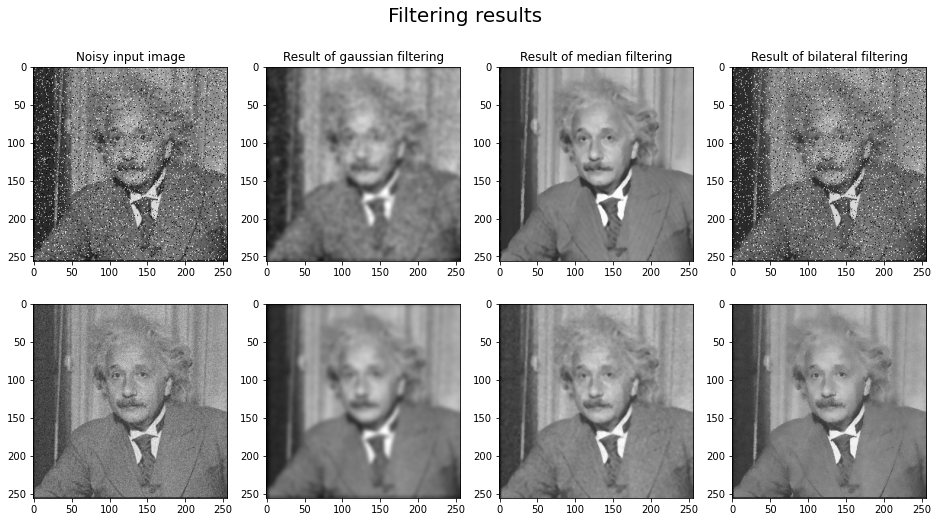

In [3]:


# Load test images and convert to double precision in the interval [0,1].
im = imread('einsteinpic.jpg') / 255.
im = imresize(im, (256, 256))

# Generate noise
imns = imnoise(im, 'salt & pepper', 0.05) * 1.             # "salt and pepper" noise
imng = im + 0.05*np.random.randn(im.shape[0],im.shape[1])  # zero-mean Gaussian noise


# Apply a Gaussian filter with a standard deviation of 2.5
sigmad = 2.5
g, _, _, _, _, _, = gaussian2(sigmad)
gflt_imns = conv2(imns, g, mode='reflect')
gflt_imng = conv2(imng, g, mode='reflect')


# filtering with g, make a separable implementation where you use horizontal and vertical 1D convolutions.

u, s, vh = np.linalg.svd(g, full_matrices=True)
vertical_array = np.sqrt(s[0])*u[:,0]
horizontal_array = np.sqrt(s[0])*vh[0,:]


gflt_imns_new = conv1(imns, vertical_array, axis=-1)
gflt_imns_new = conv1(gflt_imns_new, horizontal_array, axis=0)  

gflt_imng_new = conv1(imng, vertical_array, axis=-1)
gflt_imng_new = conv1(gflt_imng_new, horizontal_array, axis=0)  


# Median filtering is done by extracting a local patch from the input image
# and calculating its median
def median_filter(img, wsize):
    nrows, ncols = img.shape
    output = np.zeros([nrows, ncols])
    k = (wsize - 1) / 2

    for i in range(nrows):
        for j in range(ncols):
            # Calculate local region limits
            iMin = int(max(i - k, 0))
            iMax = int(min(i + k, nrows - 1))
            jMin = int(max(j - k, 0))
            jMax = int(min(j + k, ncols - 1))


            extracted_matrix = img[iMin:iMax,jMin:jMax]
            median_value = np.median(extracted_matrix)
            output[i,j] = median_value

    return output

# Apply median filtering, use neighborhood size 5x5


medflt_imns = median_filter(imns, 5) 
medflt_imng = median_filter(imng, 5)  


# Apply bilateral filter to each image with window size 11.

wsize = 11
sigma_d = 2.5
sigma_r = 0.1

bflt_imns = bilateral_filter(imns, wsize, sigma_d, sigma_r)
bflt_imng = bilateral_filter(imng, wsize, sigma_d, sigma_r)

# Display filtering results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imns, cmap='gray')
ax[0].set_title("Noisy input image")
ax[1].imshow(gflt_imns_new, cmap='gray')
ax[1].set_title("Result of gaussian filtering")
ax[2].imshow(medflt_imns, cmap='gray')
ax[2].set_title("Result of median filtering")
ax[3].imshow(bflt_imns, cmap='gray')
ax[3].set_title("Result of bilateral filtering")
ax[4].imshow(imng, cmap='gray')
ax[5].imshow(gflt_imng_new, cmap='gray')
ax[6].imshow(medflt_imng, cmap='gray')
ax[7].imshow(bflt_imng, cmap='gray')
plt.suptitle("Filtering results", fontsize=20)
plt.show()



# Image Blending

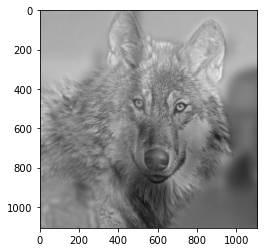

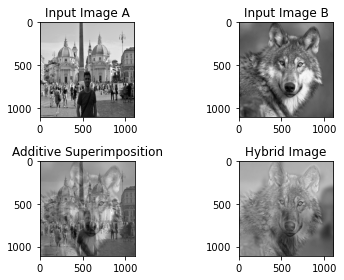

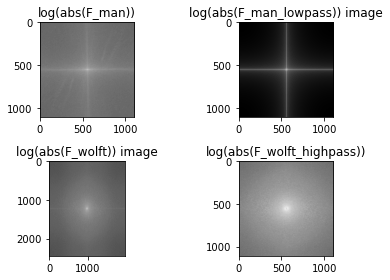

In [5]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
# Load test images
man = imread('man2.jpg') / 255.
wolf = imread('wolf.jpg') / 255.
man = rgb2gray(man)
dsize = (1107, 1107)

# resize image
man = cv2.resize(man, dsize)

# The pixel coordinates of eyes and chin have been manually found
# from both images in order to perform affine alignment
man_eyes_chin = np.array([[502, 465],   # left eye
                          [714, 485],   # right eye
                          [594, 875]])  # chin
wolf_eyes_chin = np.array([[851,  919],    # left eye
                           [1159, 947],    # right eye
                           [975,  1451]])  # chin

# Warp wolf to man using an affine transformation and the coordinates above
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)
xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size,1)).T
wolft = map_coordinates(wolf, (pt[1,:].reshape(man.shape), pt[0,:].reshape(man.shape)))

# We'll start by simply blending the aligned images using additive superimposition
additive_superimposition = man + wolft

# Next we create two different Gaussian kernels for low-pass filtering the two images
sigmaA = 24
sigmaB = 16
man_lowpass = gaussian_filter(man, sigmaA, mode='nearest')
wolft_lowpass = gaussian_filter(wolft, sigmaB, mode='nearest')


wolft_highpass = wolft - wolft_lowpass


hybrid_image = wolft_highpass + man_lowpass   

plt.figure(1)
plt.imshow(hybrid_image, cmap='gray')

# Display input images and both output images.
plt.figure(2)
plt.subplot(2,2,1)
plt.imshow(man, cmap='gray')
plt.title("Input Image A")
plt.subplot(2,2,2)
plt.imshow(wolft, cmap='gray')
plt.title("Input Image B")
plt.subplot(2,2,3)
plt.imshow(additive_superimposition, cmap='gray')
plt.title("Additive Superimposition")
plt.subplot(2,2,4)
plt.imshow(hybrid_image, cmap='gray')
plt.title("Hybrid Image")
plt.tight_layout()


F_man_fft = np.fft.fft2(man) 
F_man = np.fft.fftshift(F_man_fft)

F_man_lowpass_fft = np.fft.fft2(man_lowpass) 
F_man_lowpass = np.fft.fftshift(F_man_lowpass_fft)

F_wolft_fft = np.fft.fft2(wolf)
F_wolft = np.fft.fftshift(F_wolft_fft)

F_wolft_highpass_fft = np.fft.fft2(wolft_highpass) 
F_wolft_highpass = np.fft.fftshift(F_wolft_highpass_fft)  


# Display the Fourier transform results
plt.figure(3)
plt.subplot(2,2,1)
plt.imshow(np.log(np.abs(F_man)), cmap='gray')
plt.title("log(abs(F_man))")
plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(F_man_lowpass)), cmap='gray')
plt.title("log(abs(F_man_lowpass)) image")
plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(F_wolft)), cmap='gray')
plt.title("log(abs(F_wolft)) image")
plt.subplot(2,2,4)
plt.imshow(np.log(np.abs(F_wolft_highpass)), cmap='gray')
plt.title("log(abs(F_wolft_highpass))")
plt.tight_layout()
plt.show()
